In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.cm import ScalarMappable
from matplotlib.colors import SymLogNorm, Normalize
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

## Loading data

In [2]:
def calc_r2(x, y):
    mask = ~np.logical_or(np.isnan(x), np.isnan(y))
    return pearsonr(x[mask], y[mask])[0] ** 2


def calc_r(x, y, num=1000):
    mask = ~np.logical_or(np.isnan(x), np.isnan(y))
    x = np.asarray(x[mask])
    y = np.asarray(y[mask])

    samples = np.empty(num)
    for i in range(num):
        idx = np.random.choice(np.arange(x.size), x.size, replace=True)
        d1 = x[idx]
        d2 = y[idx]
        samples[i] = pearsonr(d1, d2)[0]

    return pearsonr(x, y)[0], np.nanstd(samples)

In [3]:
df = pd.read_csv("data/processed_data/df_hm_included.csv", index_col=0)
df_locations = gpd.read_file("data/processed_data/df_locations.geojson")
translations = pd.read_excel("data/translation_items.xlsx", index_col=0)

FIRST_ITEM = "plastic_6_packringen"
LAST_ITEM = "granulaat_korrels"
ind_item = [list(df.columns).index(x) for x in [FIRST_ITEM, LAST_ITEM]]
s_items = slice(ind_item[0], ind_item[1], None)

ITEMS = [item for item in list(df.columns)[s_items]]

df.loc[:, 'sampling'] = df.Gebiedscode.apply(lambda x: 'Reference' if "REFE" in x else 'Volunteer')
df.loc[:, 'river'] = df.Gebiedscode.apply(lambda x: x[0])
df = df.loc[df.river.isin(["W", "M"])]
df.loc[:, 'all'] = df.loc[:, ITEMS].sum(axis=1)
df.loc[:, 'season'] = df.meting.apply(lambda x: "Autumn" if x in [0,2] else "Spring")

columns = ["P_7d_max", "U_7d_max", "h_7d_max_above_current", "dop", "season", "river", "sampling"]
titles = {"P_7d_max": "Precipitation",
          "U_7d_max": "Wind speed",
          "h_7d_max_above_current": "Water height",
          "dop": "Time",
          "season": "Seasonality",
          "river": "Waal vs Meuse",
          "sampling": "Volunteer vs Reference"}

object_types = {'plastic': "Grey",
                'rubber': "Black",
                'textiel': 'Orange',
                'papier': "Yellow",
                'hout': "Brown",
                'metaal': "Silver",
                'glas': "Lightblue",
                'sanitair': "Red",
                'medisch': "Pink",
                'granulaat': "Grey"}

In [4]:
single_param_r2 = pd.DataFrame(index=ITEMS, columns=columns, dtype='float')
performance = pd.DataFrame(index=ITEMS, columns=columns, dtype='float')

multi_param_r2 = pd.DataFrame(index=ITEMS, columns=['r2'], dtype='float')
multi_param_r = pd.DataFrame(index=ITEMS, columns=['r', 'std'], dtype='float')
coefficient = pd.DataFrame(index=ITEMS, columns=columns, dtype='float')

## Modelling

### Single-parameter models

In [5]:
for parameter in columns:
    print(parameter)
    for item in ITEMS:
        if parameter in ['season', 'river', 'sampling']:
            formula = f'{item} ~ C({parameter})'
        else:
            formula = f'{item} ~ {parameter}'

        try:
            model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
        except statsmodels.tools.sm_exceptions.PerfectSeparationError:
            continue

        if parameter == 'river':
            select = "C(river)[T.W]"
        elif parameter == 'sampling':
            select = "C(sampling)[T.Volunteer]"
        elif parameter == 'season':
            select = "C(season)[T.Spring]"
        else:
            select = parameter

        true_r2 = calc_r2(df.loc[:, item], model.predict(df))
        random_r2 = pd.read_csv(f"data/item_variance/{parameter}_{item}.csv", index_col=0).iloc[:, 0]

        single_param_r2.loc[item, parameter] = true_r2
        performance.loc[item, parameter] = (random_r2 < true_r2).sum()/1000

P_7d_max
U_7d_max
h_7d_max_above_current
dop
season


/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


river
sampling


### Multi-parameter models

In [6]:
for item in ITEMS:
    formula = f'{item} ~ P_7d_max + U_7d_max + h_7d_max_above_current + dop + C(season) + C(river) + C(sampling)'
    try:
        model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(full_output=True)
    except statsmodels.tools.sm_exceptions.PerfectSeparationError:
        continue

    select = columns.copy()
    select[-3] = "C(season)[T.Spring]"
    select[-2] = "C(river)[T.W]"
    select[-1] = "C(sampling)[T.Volunteer]"

    multi_param_r2.loc[item] = calc_r2(df.loc[:, item], model.predict(df))
    multi_param_r.loc[item] = calc_r(df.loc[:, item], model.predict(df))
    coefficient.loc[item] = model.params[select].values

/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/jroebroek/opt/anaconda3/envs/current_2/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Figures

### Table plot

<ipython-input-9-a93772693cea>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = SymLogNorm(linthresh=0.01, vmin=-0.25, vmax=0.25)


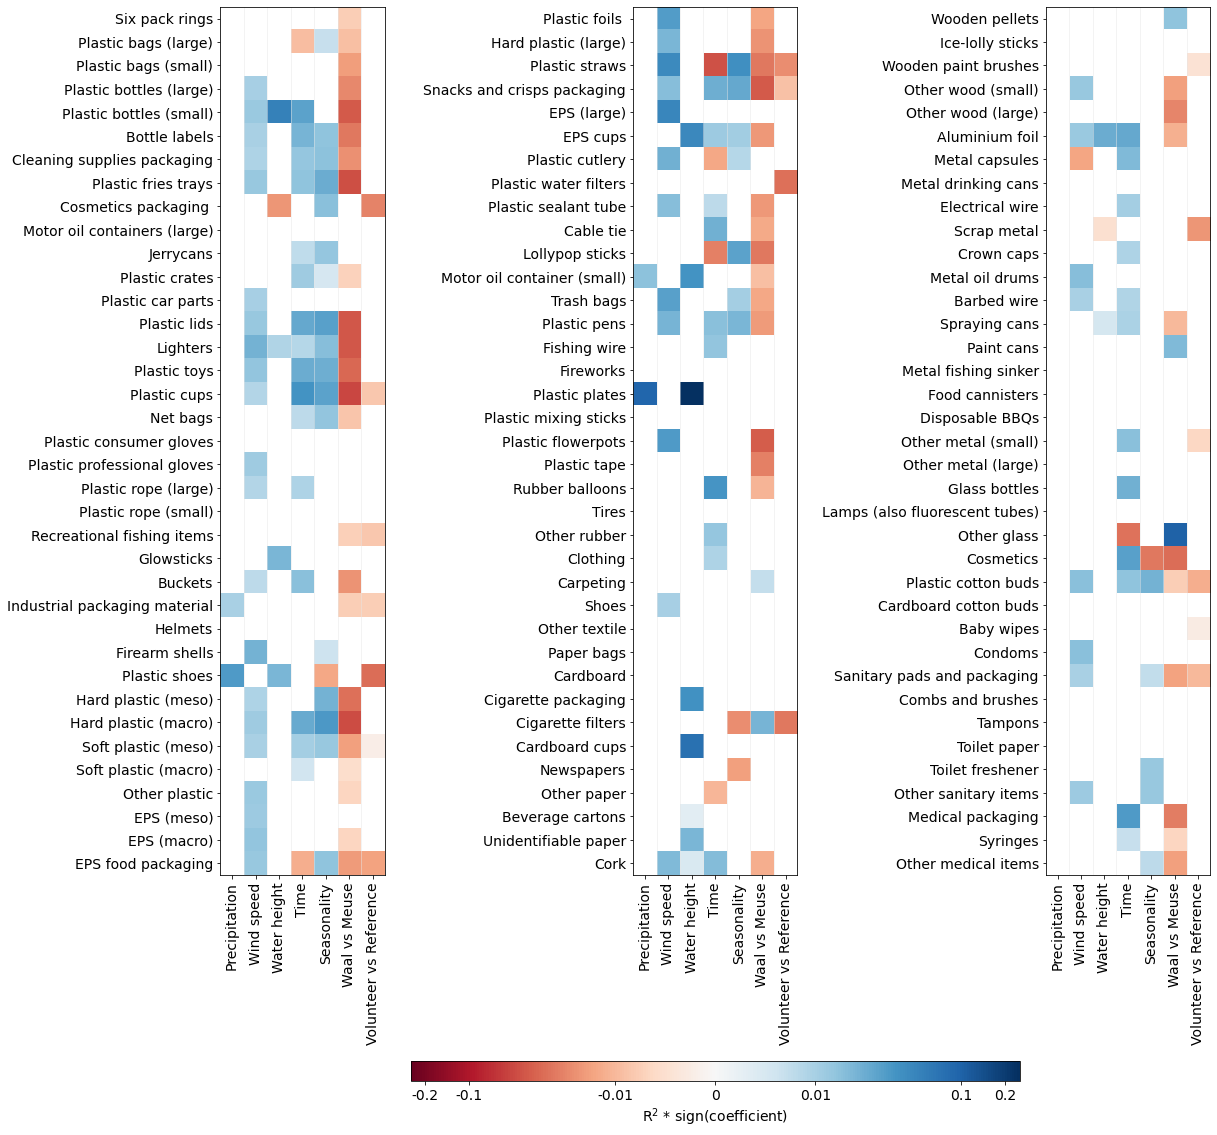

In [9]:
x = single_param_r2 * np.sign(coefficient)
x[performance < 0.9] = np.nan
x['name'] = translations.loc[x.index, 'Name']

f, ax = plt.subplots(ncols=3, figsize=(26, 20))
ax = ax.flatten()
norm = SymLogNorm(linthresh=0.01, vmin=-0.25, vmax=0.25)
cmap = "RdBu"
for i in range(3):
    ax[i].imshow(x.iloc[i*37:(i+1)*37, :-1], cmap=cmap, norm=norm,
                 origin='upper')
    ax[i].set_xticks(np.arange(0, 7))
    ax[i].set_xticklabels([titles[i] for i in list(x.columns)[:-1]], rotation=90)
    ax[i].set_yticks(np.arange(0, 37))
    ax[i].set_yticklabels(list(x.name.values)[i*37:(i+1)*37])
    for ii in range(7):
        ax[i].axvline(ii-0.5, color=(0.9, 0.9, 0.9, 0.6), linewidth=0.8)
plt.tight_layout(w_pad=-36)
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation="horizontal",
             pad=0.15, aspect=30, shrink=0.35)
cbar.set_ticks([-0.2, -0.1, -0.01, 0, 0.01, 0.1, 0.2])
cbar.set_ticklabels([-0.2, -0.1, -0.01, 0, 0.01, 0.1, 0.2])
cbar.set_label(r"R$\rm^{2}$ * sign(coefficient)")
plt.savefig("figures/coefficient_table.png", bbox_inches='tight', dpi=300)
plt.show()

### Christmas tree

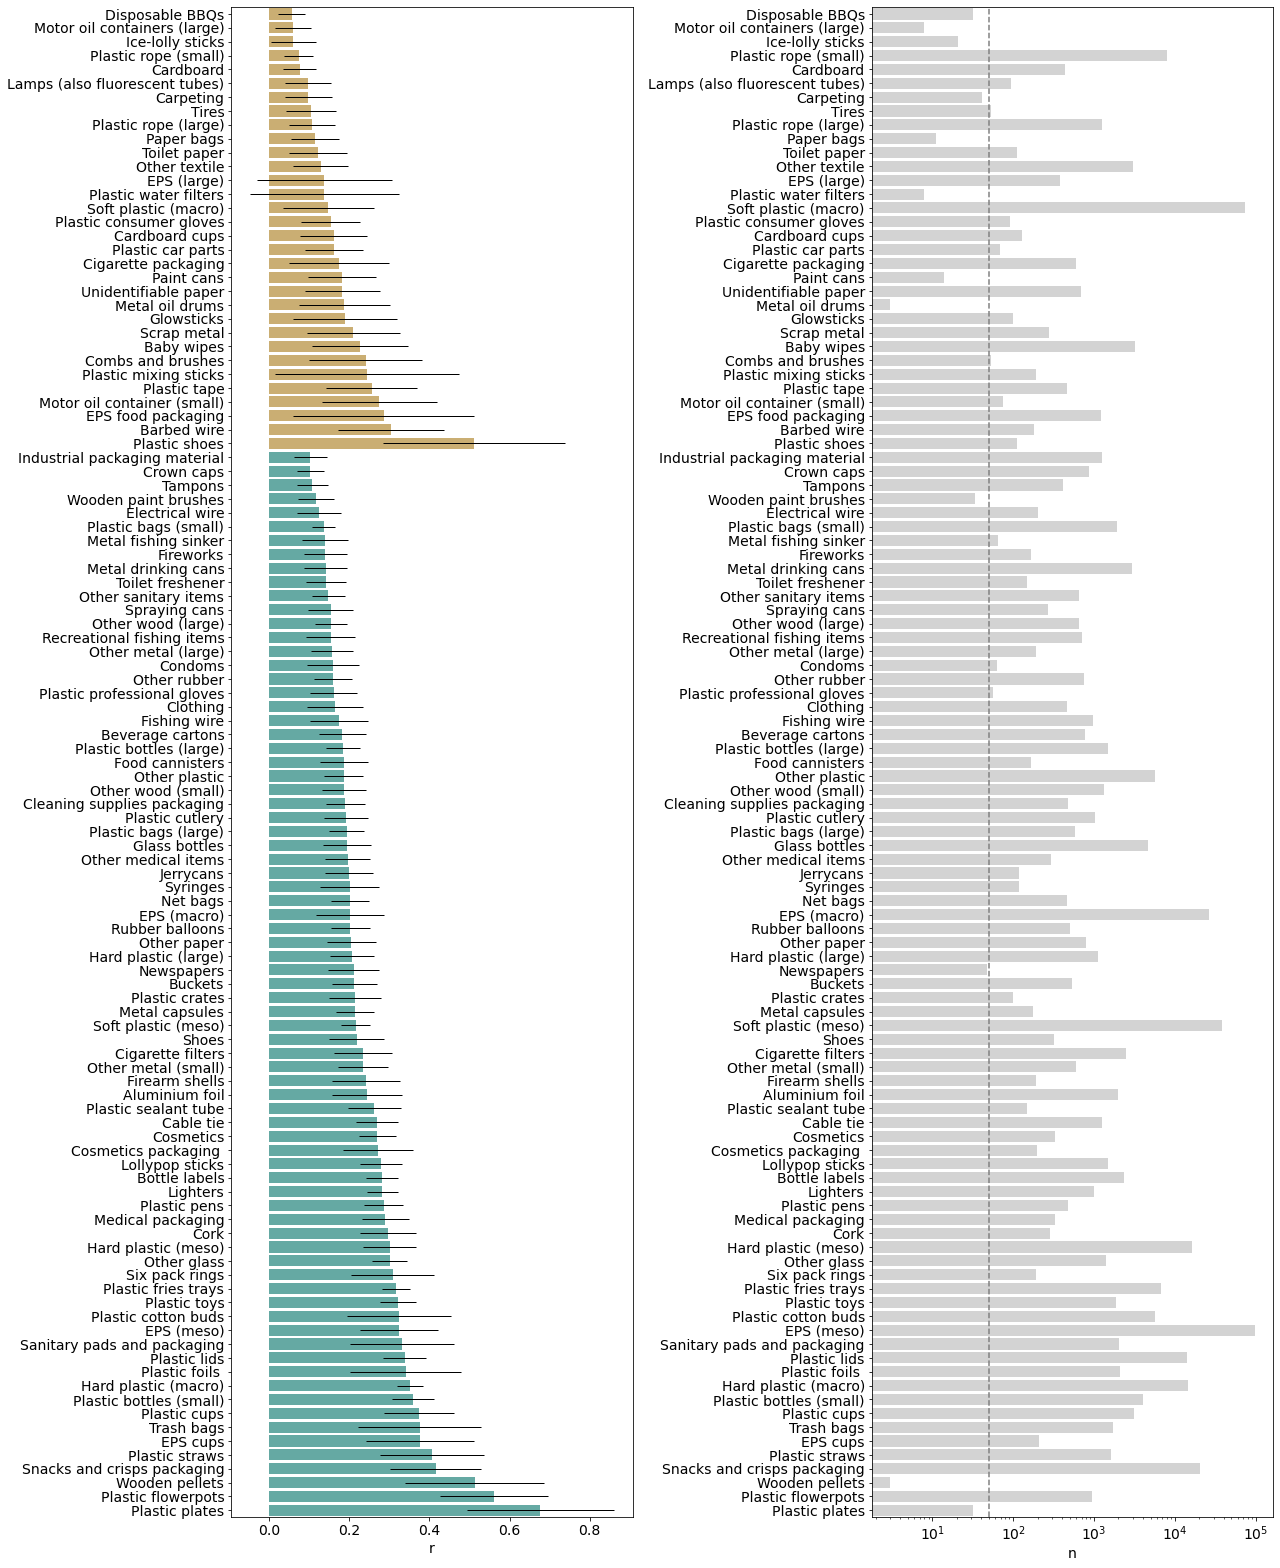

In [10]:
df_items = multi_param_r.copy()
df_items.index = translations.loc[df_items.index, "Name"].values
df_items.columns = ['r', 'sd']
df_items.loc[:, 'threshold'] = df_items.r - df_items.sd * 2.3
df_items = df_items.loc[df_items.threshold < 0, :].sort_values("r").append(df_items.loc[df_items.threshold >= 0, :].sort_values("r"))
df_items.loc[:, "color"] = df_items.apply(lambda x: "#5ab4ac" if x.threshold > 0 else "#d8b365", axis=1)

f, ax = plt.subplots(ncols=2, figsize=(18, 22))
ax = ax.flatten()
sns.barplot(data=df_items, x="r", y=df_items.index, ci="None", ax=ax[0], palette=df_items.color)
ylim = ax[0].get_ylim()
ax[0].errorbar(x=df_items.r, y=df_items.index, fmt='none', xerr=df_items.sd, ecolor='k', elinewidth=1)
ax[0].set_ylim(ylim)

count = pd.DataFrame(df.loc[:, ITEMS].sum(), columns=['n'])
count.index = translations.loc[count.index, "Name"].values
count = count.loc[df_items.index, :]
sns.barplot(data=count, x='n', y=count.index, color='lightgrey', ax=ax[1])
ax[1].set_xscale('log')
ax[1].axvline(50, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig("figures/multi_parameter_r.png", dpi=300, bbox_inches='tight')
plt.show()

## Significantly explained

In [12]:
objects = translations.loc[[item for item in ITEMS if "0_2_5" not in item and \
                            "helmen" not in item and \
                            "granulaat" not in item], "Name"].values
count_select = count.loc[count.index.intersection(objects), :]
df_items_select = df_items.loc[df_items.index.intersection(objects), :]

print("unselected")
print(f"predictable items: {count.loc[(df_items.threshold > 0)].sum().values}")
print(f"unpredictable items: {count.loc[~(df_items.threshold > 0)].sum().values}")
print(f"fraction: {(count.loc[(df_items.threshold > 0)].sum()/(count.loc[~(df_items.threshold > 0)].sum()+count.loc[(df_items.threshold > 0)].sum())).values}")
print("selected")
print(f"predictable items: {count_select.loc[(df_items_select.threshold > 0)].sum().values}")
print(f"unpredictable items: {count_select.loc[~(df_items_select.threshold > 0)].sum().values}")
print(f"fraction: {(count_select.loc[(df_items_select.threshold > 0)].sum()/(count_select.loc[~(df_items_select.threshold > 0)].sum()+count_select.loc[(df_items_select.threshold > 0)].sum())).values}")

unselected
predictable items: [305652.]
unpredictable items: [94390.]
fraction: [0.76404977]
selected
predictable items: [153962.]
unpredictable items: [94390.]
fraction: [0.61993461]
